In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

## Loading the data

In [3]:
yellow = pd.read_csv('yellow.csv')
green = pd.read_csv('green.csv')
FHVHV = pd.read_csv('FHVHV.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'yellow.csv'

In [98]:
yellow.head(2)

,month_date,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,...,date,month_year1,trips_per_month,farebox_per_month,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent
60,2015-01-28,Yellow,411238,5442278,31236,13633,12721,28.9,13.4,21.5,...,2015-01,2015-01,12748378,168710618,4,2878666,2015,38095946,411238,0.0
61,2015-02-28,Yellow,444633,6097785,30969,13617,12979,26.7,14.1,20.3,...,2015-02,2015-02,12449724,170737980,8,3112431,2015,42684495,444633,0.0


In [115]:
# Establece la fecha como index
Y = yellow.copy()
Y['date'] = pd.to_datetime(Y['date'], format='%Y/%m')
Y = Y.set_index('date')
Y = Y.sort_index()
Y = Y.asfreq('MS')
Y.head(2)


,month_date,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,...,trips_per_day_shared,month_year1,trips_per_month,farebox_per_month,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2015-01-28,Yellow,411238,5442278,31236,13633,12721,28.9,13.4,21.5,...,0,2015-01,12748378,168710618,4,2878666,2015,38095946,411238,0.0
2015-02-01,2015-02-28,Yellow,444633,6097785,30969,13617,12979,26.7,14.1,20.3,...,0,2015-02,12449724,170737980,8,3112431,2015,42684495,444633,0.0


In [112]:
print(f'Missing values: {Y.isnull().any(axis=1).mean()}')

Missing values: 0.0


In [117]:
Y.index.freq

<MonthBegin>

In [118]:
# Verificar que un índice temporal está completo
# ==============================================================================
(Y.index == pd.date_range(start = Y.index.min(),end = Y.index.max(), freq = Y.index.freq)).all()

True

Fechas train : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=48)
Fechas test  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


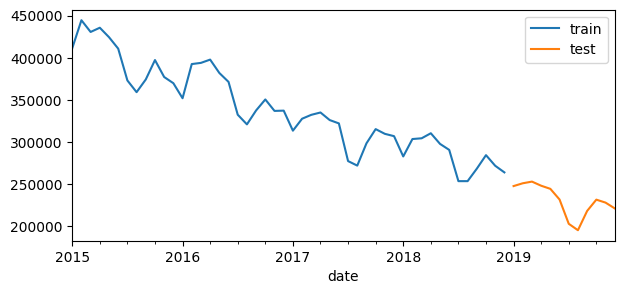

In [126]:
# Separación Y train-test
# ==============================================================================
steps = 12
datos_train = Y[:-steps]
datos_test  = Y[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['trips_per_day'].plot(ax=ax, label='train')
datos_test['trips_per_day'].plot(ax=ax, label='test')
ax.legend()

In [127]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [128]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24)

forecaster.fit(y=datos_train['trips_per_day'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-08 12:35:06 
Last fit date: 2023-04-08 12:35:06 
Skforecast version: 0.7.0 
Python version: 3.10.10 
Forecaster id: None 

In [134]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2019-01-01    271887.93
2019-02-01    274279.06
2019-03-01    274520.41
2019-04-01    268949.41
2019-05-01    273371.83
Freq: MS, Name: pred, dtype: float64

In [135]:
predicciones

2019-01-01    271887.93
2019-02-01    274279.06
2019-03-01    274520.41
2019-04-01    268949.41
2019-05-01    273371.83
2019-06-01    274487.19
2019-07-01    275397.87
2019-08-01    274865.01
2019-09-01    274702.60
2019-10-01    274581.46
2019-11-01    275559.42
2019-12-01    275180.77
Freq: MS, Name: pred, dtype: float64

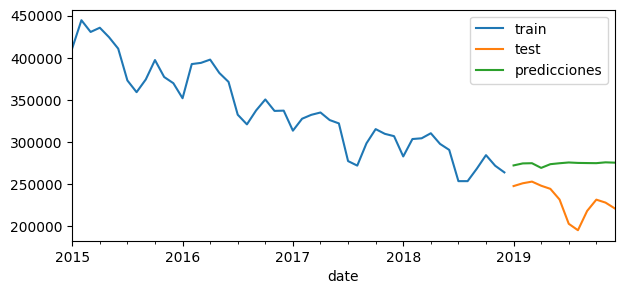

In [136]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['trips_per_day'].plot(ax=ax, label='train')
datos_test['trips_per_day'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [137]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['trips_per_day'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 2244152241.755633


In [146]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 18
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 2 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [6,9,12]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [250, 500, 750],
              'max_depth': [3, 6, 9, 12]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['trips_per_day'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 36.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [02:02<00:00, 40.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 1018342460.5368704



In [147]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 250}",1.018342e+09,3,250
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 12, 'n_estimators': 250}",1.021026e+09,12,250
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 250}",1.021026e+09,9,250
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 6, 'n_estimators': 250}",1.021184e+09,6,250
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 12, 'n_estimators': 500}",1.067435e+09,12,500
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 500}",1.067435e+09,9,500
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 6, 'n_estimators': 500}",1.067529e+09,6,500
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 500}",1.069363e+09,3,500
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 12, 'n_estimators': 750}",1.079544e+09,12,750
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 750}",1.079544e+09,9,750


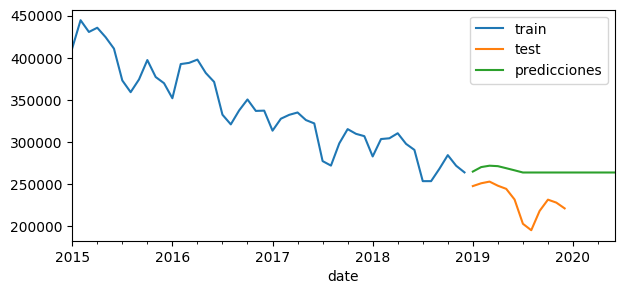

In [148]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 12)
forecaster.fit(y=datos_train['trips_per_day'])
steps = 18
predicciones = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['trips_per_day'].plot(ax=ax, label='train')
datos_test['trips_per_day'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [151]:
Y = Y.trips_per_day
Y

date
2015-01-01    411238
2015-02-01    444633
2015-03-01    430669
2015-04-01    435701
2015-05-01    424459
2015-06-01    410831
2015-07-01    372979
2015-08-01    359029
2015-09-01    374156
2015-10-01    397244
2015-11-01    377076
2015-12-01    369686
2016-01-01    351816
2016-02-01    392470
2016-03-01    393886
2016-04-01    397780
2016-05-01    381878
2016-06-01    371257
2016-07-01    332231
2016-08-01    320718
2016-09-01    337321
2016-10-01    350380
2016-11-01    336737
2016-12-01    337071
2017-01-01    313229
2017-02-01    327451
2017-03-01    332075
2017-04-01    334865
2017-05-01    325857
2017-06-01    321877
2017-07-01    277042
2017-08-01    271676
2017-09-01    298163
2017-10-01    315084
2017-11-01    309471
2017-12-01    306706
2018-01-01    282565
2018-02-01    303280
2018-03-01    304169
2018-04-01    310169
2018-05-01    297508
2018-06-01    290362
2018-07-01    253186
2018-08-01    253182
2018-09-01    267983
2018-10-01    284121
2018-11-01    271501
2018-12-

## Interpolation

In [152]:
Y = Y.resample('D').interpolate(method='linear')
Y.head(3)

date
2015-01-01    411238.000000
2015-01-02    412315.258065
2015-01-03    413392.516129
Freq: D, Name: trips_per_day, dtype: float64

In [155]:
print(f'Missing values: {Y.isnull().any().mean()}')

Missing values: 0.0


In [157]:
# Verificar que un índice temporal está completo
# ==============================================================================
(Y.index == pd.date_range(start = Y.index.min(),end = Y.index.max(), freq = Y.index.freq)).all()

True

Fechas train : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=1431)
Fechas test  : 2018-12-02 00:00:00 --- 2019-12-01 00:00:00  (n=365)


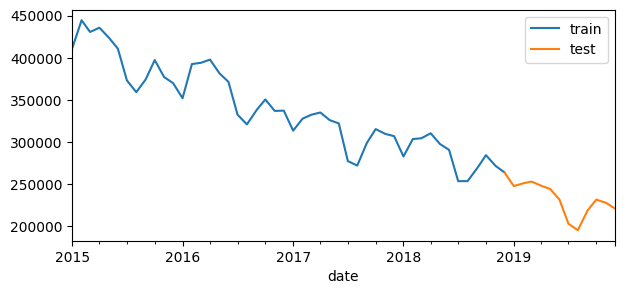

In [162]:
# Separación Y train-test
# ==============================================================================
steps = 365
datos_train = Y[:-steps]
datos_test  = Y[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend()

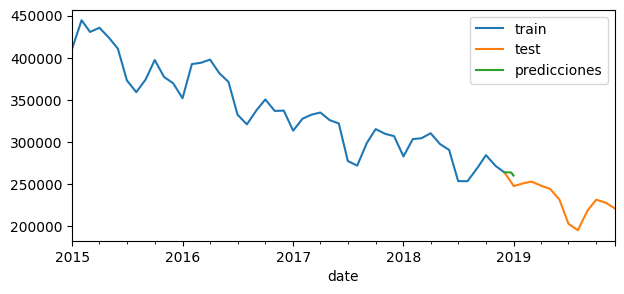

In [184]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 390)
forecaster.fit(y=datos_train)
steps = 30
predicciones = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [176]:
# Grid search de hiperparámetros
# ==============================================================================
switch = False
if switch:
      steps = 365
      forecaster = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 7 # Este valor será remplazado en el grid search
                  )

      # Lags utilizados como predictores
      lags_grid = [7,30,365]

      # Hiperparámetros del regresor
      param_grid = {'n_estimators': [250, 500, 750],
                  'max_depth': [3, 6, 9, 12]}

      resultados_grid = grid_search_forecaster(
                              forecaster         = forecaster,
                              y                  = datos_train,
                              param_grid         = param_grid,
                              lags_grid          = lags_grid,
                              steps              = steps,
                              refit              = True,
                              metric             = 'mean_squared_error',
                              initial_train_size = int(len(datos_train)*0.5),
                              fixed_train_size   = False,
                              return_best        = True,
                              verbose            = False)

Number of models compared: 36.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [41:24<00:00, 828.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 12, 'n_estimators': 750}
  Backtesting metric: 457755135.9849169



In [177]:
# Resultados Grid Search
# ==============================================================================
# resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 12, 'n_estimators': 750}",4.577551e+08,12,750
9,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 12, 'n_estimators': 250}",4.866865e+08,12,250
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 9, 'n_estimators': 500}",4.892041e+08,9,500
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 12, 'n_estimators': 500}",4.901727e+08,12,500
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 12, 'n_estimators': 250}",5.231654e+08,12,250
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 9, 'n_estimators': 750}",5.340777e+08,9,750
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 9, 'n_estimators': 250}",5.343425e+08,9,250
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 250}",5.373838e+08,6,250
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 750}",5.389715e+08,6,750
3,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 6, 'n_estimators': 250}",5.392101e+08,6,250


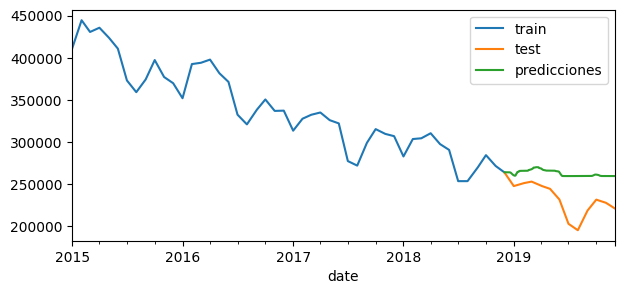

In [182]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 520)
forecaster.fit(y=datos_train)
steps = 365
predicciones = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

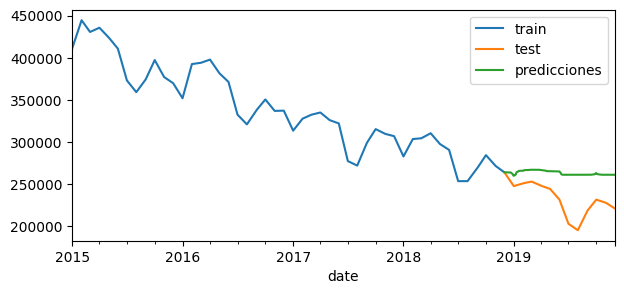

In [188]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=12, n_estimators=750, random_state=123)
forecaster = ForecasterAutoreg(regressor = regressor,lags= 390)
forecaster.fit(y=datos_train)
steps = 365
predicciones = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [189]:
predicciones

2018-12-02    263720.470105
2018-12-03    263706.961416
2018-12-04    263695.460757
2018-12-05    263689.965468
2018-12-06    263679.001784
                  ...      
2019-11-27    260768.821156
2019-11-28    260768.821156
2019-11-29    260768.821156
2019-11-30    260768.821156
2019-12-01    260769.457758
Freq: D, Name: pred, Length: 365, dtype: float64

## Preprocessing the data

In [228]:
x = Y.index
y = Y.values
print(x.shape)
y.shape

(1796,)


(1796,)

In [231]:
x = x.values.reshape((-1,1))
x.shape

(1796, 1)

In [216]:
x = x.reshape((-1,1))
x.shape

(1796, 1)

In [217]:
# Standarization
from sklearn.preprocessing import StandardScaler
# x = x.reshape((1,-1))
scaler = StandardScaler().fit(x)
standardized_X = scaler.transform(x)

In [218]:
# Generating Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4, include_bias=False)
poly.fit_transform(x)

array([[1.42007040e+18, 2.01659994e+36, 2.86371388e+54, 4.06667532e+72],
       [1.42015680e+18, 2.01684534e+36, 2.86423662e+54, 4.06766511e+72],
       [1.42024320e+18, 2.01709075e+36, 2.86475942e+54, 4.06865508e+72],
       ...,
       [1.57498560e+18, 2.48057964e+36, 3.90687721e+54, 6.15327535e+72],
       [1.57507200e+18, 2.48085181e+36, 3.90752021e+54, 6.15462568e+72],
       [1.57515840e+18, 2.48112399e+36, 3.90816329e+54, 6.15597623e+72]])

## Modeling

In [232]:
# Supervised Learning Estimators
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

## Model fitting

In [233]:

lr.fit(x, y) # Simple

LinearRegression()

In [240]:
x

array([['2015-01-01T00:00:00.000000000'],
       ['2015-01-02T00:00:00.000000000'],
       ['2015-01-03T00:00:00.000000000'],
       ...,
       ['2019-11-29T00:00:00.000000000'],
       ['2019-11-30T00:00:00.000000000'],
       ['2019-12-01T00:00:00.000000000']], dtype='datetime64[ns]')

In [234]:
lr.predict(x) 

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

## Prediction

In [221]:
y_pred = lr.predict(x) 

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

ValueError: x and y must have same first dimension, but have shapes (1796, 1) and (60,)

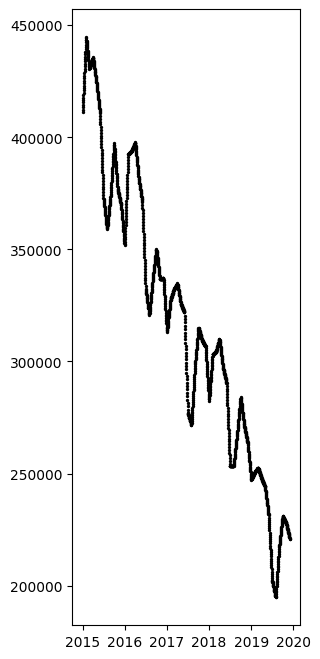

In [225]:
plt.figure(figsize = (10,8))
plt.subplot(1,3,1)
plt.scatter(x,y, s = 2, label = 'Datos', color = 'black')
plt.plot(x, y_pred, '--',label ='Curva Teórica', c = 'r')

# list1, list2 = zip(*sorted(zip(X_train_new[:,0], y_train_pred_2)))
# plt.plot(list1, list2,label ='Regresión (train)')

plt.legend()
plt.show()

In [40]:
yellow['month_date'] = pd.to_datetime(yellow['month_date'])
green['month_date'] = pd.to_datetime(green['month_date'])
FHVHV['month_date'] = pd.to_datetime(FHVHV['month_date'])

In [52]:
yellow['month_date'] = pd.to_numeric(yellow['month_date'])

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_94359/2525043759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yellow['month_date'] = pd.to_numeric(yellow['month_date'])


In [42]:
yellow['month_date'].corr(yellow['trips_per_day'])

-0.92990273445316

In [62]:
yellow['month_date'].to_timestamp()

TypeError: unsupported Type Int64Index

In [57]:
# Acotar los datos desde enero de 2015 hasta diciembre de 2019 (Inicio de crecimiento FHVHV hasta COVID-19)
yellow['month_date'] = pd.to_datetime(yellow['month_date'])
start = pd.Timestamp('2015-01-01')
end = pd.Timestamp('2019-12-31')
yellow = yellow.loc[(yellow['month_date'].values >= start) & (yellow['month_date'].values <= end)]

# Calcular la correlación lineal
corr = yellow['month_date'].corr(yellow['trips_per_day'])
# Graficar la relación entre las variables
plt.scatter(x=yellow['month_date'], y=yellow['trips_per_day'])
plt.xlabel('month_date')
plt.ylabel('trips_per_day')
plt.title(f'Correlación lineal: {corr:.2f}')
plt.show()

TypeError: reduction operation 'corr' not allowed for this dtype

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_94359/528290536.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = green.corr().iloc[0,1]


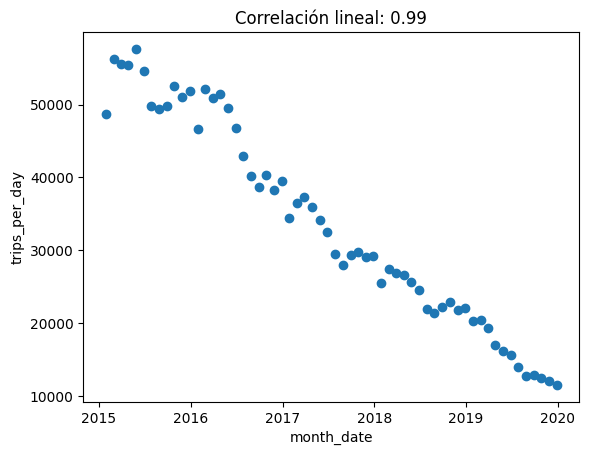

In [9]:
# Acotar los datos desde enero de 2015 hasta diciembre de 2019 (Inicio de crecimiento FHVHV hasta COVID-19)
green = green.loc[(green['month_date'] >= '2015-01-01') & (green['month_date'] <= '2019-12-31')]

# Calcular la correlación lineal
corr = green.corr().iloc[0,1]
# Graficar la relación entre las variables
plt.scatter(x=green['month_date'], y=green['trips_per_day'])
plt.xlabel('month_date')
plt.ylabel('trips_per_day')
plt.title(f'Correlación lineal: {corr:.2f}')
plt.show()

In [28]:
yellow.loc[(yellow['month_date'] >= '2015-01-01') & (yellow['month_date'] <= '2019-12-31')]

,month_date,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,...,date,month_year1,trips_per_month,farebox_per_month,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent
60,2015-01-28,Yellow,411238,5442278,31236,13633,12721,28.9,13.4,21.5,...,2015-01,2015-01,12748378,168710618,4,2878666,2015,38095946,411238,0.0
61,2015-02-28,Yellow,444633,6097785,30969,13617,12979,26.7,14.1,20.3,...,2015-02,2015-02,12449724,170737980,8,3112431,2015,42684495,444633,0.0
62,2015-03-28,Yellow,430669,6076181,31610,13584,13030,29.7,14.0,22.3,...,2015-03,2015-03,13350739,188361611,12,3014683,2015,42533267,430669,0.0
63,2015-04-28,Yellow,435701,6226205,31574,13577,13098,28.9,14.2,21.9,...,2015-04,2015-04,13071030,186786150,17,3049907,2015,43583435,435701,0.0
64,2015-05-28,Yellow,424459,6239552,31442,13580,13006,29.7,14.1,22.4,...,2015-05,2015-05,13158229,193426112,21,2971213,2015,43676864,424459,0.0
65,2015-06-28,Yellow,410831,6014938,30829,13549,12990,28.8,13.8,21.9,...,2015-06,2015-06,12324930,180448140,25,2875817,2015,42104566,410831,0.0
66,2015-07-28,Yellow,372979,5392570,29999,13490,12599,29.0,13.1,21.8,...,2015-07,2015-07,11562349,167169670,30,2610853,2015,37747990,372979,0.0
67,2015-08-28,Yellow,359029,5200177,29688,13442,12579,29.0,13.1,21.7,...,2015-08,2015-08,11129899,161205487,34,2513203,2015,36401239,359029,0.0
68,2015-09-28,Yellow,374156,5520038,29912,13423,12523,28.0,13.2,20.8,...,2015-09,2015-09,11224680,165601140,39,2619092,2015,38640266,374156,0.0
69,2015-10-28,Yellow,397244,5856687,30104,13436,12787,29.5,13.7,22.4,...,2015-10,2015-10,12314564,181557297,43,2780708,2015,40996809,397244,0.0


In [33]:
FHVHV.loc[(FHVHV['month_date'] >= '2015-01-01') & (FHVHV['month_date'] <= '2019-12-31')]

,month_date,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,...,month_year,month_year1,trips_per_month,farebox_per_month,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent
0,2015-01-28,FHV - High Volume,60357,0,13153,12544,7265,18.0,5.4,17.6,...,Jan-2015,2015-01,1871067,0,4,422499,2015,0,60357,0.00
1,2015-02-28,FHV - High Volume,77796,0,14180,13531,8402,17.4,5.8,17.1,...,Feb-2015,2015-02,2178288,0,8,544572,2015,0,77796,0.00
2,2015-03-28,FHV - High Volume,72889,0,14995,14290,8579,18.6,5.5,18.2,...,Mar-2015,2015-03,2259559,0,12,510223,2015,0,72889,0.00
3,2015-04-28,FHV - High Volume,82498,0,16473,16006,9711,18.2,5.6,17.8,...,Apr-2015,2015-04,2474940,0,17,577486,2015,0,82498,0.00
4,2015-05-28,FHV - High Volume,94103,0,19076,14122,8120,17.8,5.4,18.0,...,May-2015,2015-05,2917193,0,21,658721,2015,0,94103,0.00
5,2015-06-28,FHV - High Volume,102793,0,20452,19840,12089,18.3,5.6,17.9,...,Jun-2015,2015-06,3083790,0,25,719551,2015,0,102793,0.00
6,2015-07-28,FHV - High Volume,112207,0,22070,22646,13358,18.3,5.5,17.5,...,Jul-2015,2015-07,3478417,0,30,785449,2015,0,112207,0.00
7,2015-08-28,FHV - High Volume,123807,0,25085,24452,14485,18.4,5.6,18.0,...,Aug-2015,2015-08,3838017,0,34,866649,2015,0,123807,0.00
8,2015-09-28,FHV - High Volume,144300,0,26914,26050,15814,18.2,5.8,17.8,...,Sep-2015,2015-09,4329000,0,39,1010100,2015,0,144300,0.00
9,2015-10-28,FHV - High Volume,163168,0,29151,28002,17701,19.6,5.8,19.1,...,Oct-2015,2015-10,5058208,0,43,1142176,2015,0,163168,0.00


In [34]:
FHVHV.corr() #.iloc[0,1]

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_94359/1130718883.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  FHVHV.corr() #.iloc[0,1]


,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,avg_hours_per_day_per_driver,avg_minutes_per_trip,percent_of_trips_paid_with_credit_card,trips_per_day_shared,trips_per_month,farebox_per_month,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent
trips_per_day,1.000000,NaN,0.976813,0.978487,0.984671,0.726754,0.552495,0.757505,0.498254,0.810294,NaN,0.684202,0.997698,NaN,0.111879,1.000000,0.594220,NaN,0.982660,0.657250
farebox_per_day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_drivers,0.976813,NaN,1.000000,0.999328,0.990660,0.706551,0.453818,0.720235,0.395355,0.769289,NaN,0.679487,0.977657,NaN,0.154866,0.976813,0.533646,NaN,0.962710,0.671216
unique_vehicles,0.978487,NaN,0.999328,1.000000,0.990155,0.699333,0.465587,0.716613,0.407013,0.777701,NaN,0.684367,0.979075,NaN,0.147044,0.978487,0.539196,NaN,0.965305,0.675762
vehicles_per_day,0.984671,NaN,0.990660,0.990155,1.000000,0.772619,0.438860,0.784462,0.377831,0.761258,NaN,0.699738,0.983542,NaN,0.158185,0.984671,0.511851,NaN,0.974213,0.684333
avg_days_vehicles_on_road,0.726754,NaN,0.706551,0.699333,0.772619,1.000000,0.184977,0.968415,0.125868,0.457499,NaN,0.507667,0.743037,NaN,0.287336,0.726754,0.240401,NaN,0.716801,0.487867
avg_hours_per_day_per_vehicle,0.552495,NaN,0.453818,0.465587,0.438860,0.184977,1.000000,0.297245,0.984280,0.698073,NaN,0.039634,0.549028,NaN,0.071824,0.552495,0.838215,NaN,0.456883,0.014909
avg_days_drivers_on_road,0.757505,NaN,0.720235,0.716613,0.784462,0.968415,0.297245,1.000000,0.249927,0.545318,NaN,0.525607,0.772539,NaN,0.275807,0.757505,0.318309,NaN,0.746231,0.503241
avg_hours_per_day_per_driver,0.498254,NaN,0.395355,0.407013,0.377831,0.125868,0.984280,0.249927,1.000000,0.673476,NaN,0.009197,0.495044,NaN,0.047952,0.498254,0.820032,NaN,0.405280,-0.015252
avg_minutes_per_trip,0.810294,NaN,0.769289,0.777701,0.761258,0.457499,0.698073,0.545318,0.673476,1.000000,NaN,0.523915,0.811463,NaN,0.157735,0.810294,0.743816,NaN,0.788492,0.544151


In [16]:
# Acotar los datos desde enero de 2015 hasta diciembre de 2019 (Inicio de crecimiento FHVHV hasta COVID-19)
FHVHV = FHVHV.loc[(FHVHV['month_date'] >= '2015-01-01') & (FHVHV['month_date'] <= '2019-12-31')]
# Eliminar filas con valores faltantes en ambas columnas
FHVHV = FHVHV['trips_per_day'].dropna()
# Calcular la correlación lineal
corr = FHVHV.corr().iloc[0,1]
# Graficar la relación entre las variables
plt.scatter(x=FHVHV['month_date'], y=FHVHV['trips_per_day'])
plt.xlabel('month_date')
plt.ylabel('trips_per_day')
plt.title(f'Correlación lineal: {corr:.2f}')
plt.show()

TypeError: Series.corr() missing 1 required positional argument: 'other'

## Series de Tiempo ARIMA

In [244]:
import datetime as datetime

In [241]:
yellow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 60 to 119
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   month_date                              60 non-null     datetime64[ns]
 1   license_class                           60 non-null     object        
 2   trips_per_day                           60 non-null     int64         
 3   farebox_per_day                         60 non-null     int64         
 4   unique_drivers                          60 non-null     int64         
 5   unique_vehicles                         60 non-null     int64         
 6   vehicles_per_day                        60 non-null     int64         
 7   avg_days_vehicles_on_road               60 non-null     float64       
 8   avg_hours_per_day_per_vehicle           60 non-null     float64       
 9   avg_days_drivers_on_road                60 non-null   

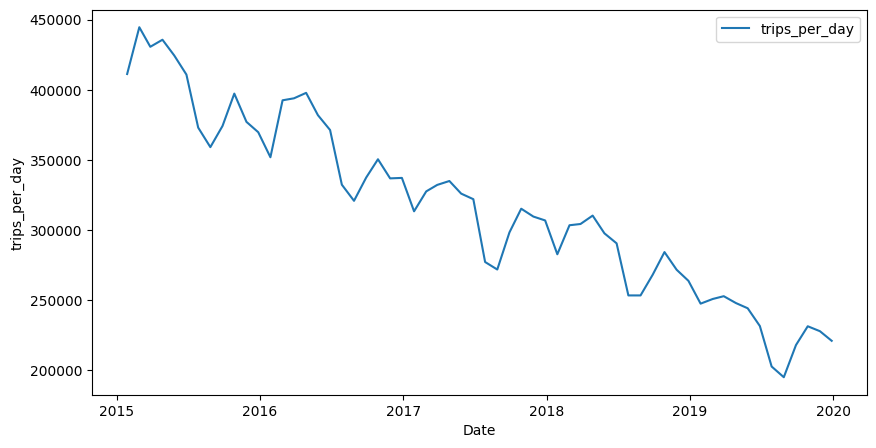

In [243]:
plt.figure(figsize = (10,5))
plt.plot(yellow.month_date, yellow.trips_per_day, label = 'trips_per_day')
# plt.plot(yellow.month_date, yellow.farebox_per_day, label = 'farebox_per_day')
plt.legend()
plt.xlabel('Date')
plt.ylabel('trips_per_day')
#plt.xlim(datetime.date(2015,1,1), datetime.date(2020,1,1))
plt.show()

In [253]:
yellow['num_date']=yellow.month_date.map(datetime.datetime.toordinal)
yellow.set_index('month_date',inplace=True)

In [254]:
from sklearn.linear_model import LinearRegression
reg_lineal = LinearRegression() #Instanciamos el modelo
reg_lineal.fit(yellow.num_date.values.reshape(-1, 1), yellow.trips_per_day) # Lo entrenamos

LinearRegression()

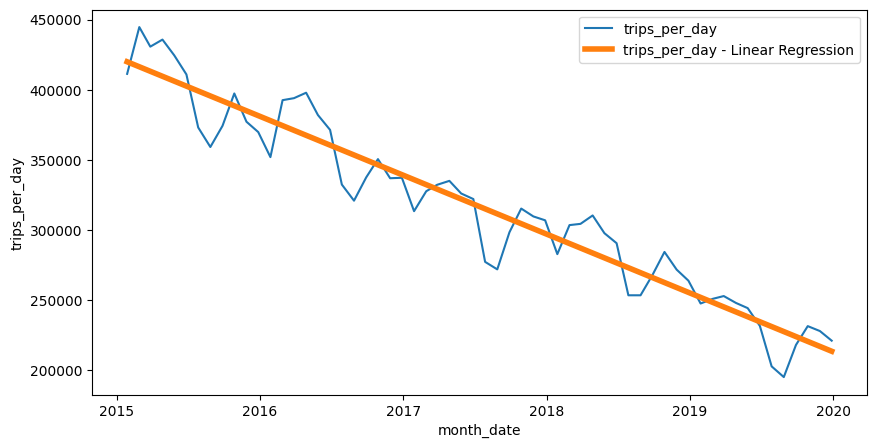

In [258]:
plt.figure(figsize = (10,5)) 
plt.plot(yellow.index, yellow.trips_per_day, label = 'trips_per_day')
plt.plot(yellow.index, reg_lineal.predict(yellow.num_date.values.reshape(-1, 1)), lw = 4, label = 'trips_per_day - Linear Regression')
plt.xlabel('month_date')
plt.ylabel('trips_per_day')
plt.legend()
plt.show()

## Estacionalidad

Text(0, 0.5, 'Trips per day')

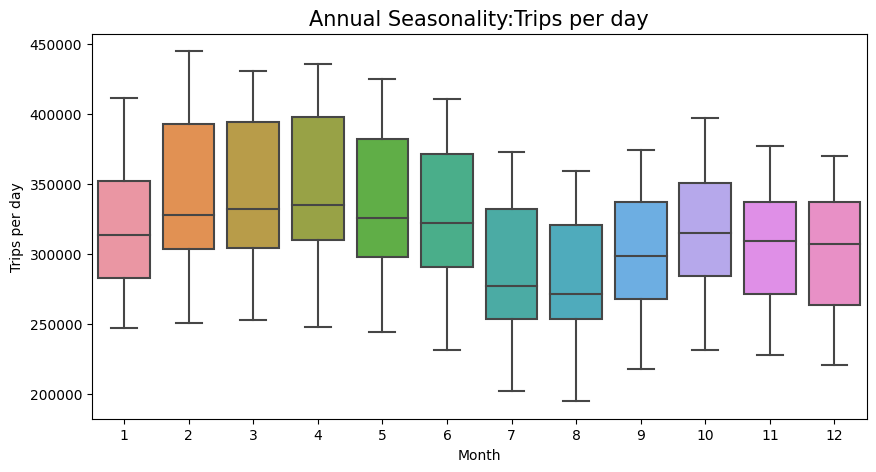

In [260]:
# Agrupamos los datos por mes y mostramos las distribuciones de cada grupo. De esta manera, se visualiza la estacionalidad anual.
plt.figure(figsize = (10,5))
sns.boxplot(data=yellow,x=yellow.index.month,y= yellow.trips_per_day)
plt.title('Annual Seasonality:Trips per day', fontsize = 15)
plt.xlabel('Month')
plt.ylabel('Trips per day')

In [262]:
### Verificamos la estacionariedad
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(yellow['trips_per_day'])

In [263]:
#H0: No es estacionaria
#H1: Es estacionaria
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print('El valor de p es menor a 0.05, lo que significa que podemos recharzar la hipótesis nula H0. Podemos concluir que los datos no tienen raíz unitaria y son estacionarios.')
    else:
        print('Evidencia débil contra la hipótesis nula, lo cual significa que la serie de tiempo tiene una raíz unitaria que indica que no es estacionaria.')

In [264]:
adfuller_test(yellow['trips_per_day'])

ADF Test Statistic : 0.23771362782248637
p-value : 0.9742992584666779
#Lags Used : 11
Number of Observations Used : 48
Evidencia débil contra la hipótesis nula, lo cual significa que la serie de tiempo tiene una raíz unitaria que indica que no es estacionaria.


La diferenciación ($\Delta^n$) ayuda a eliminar los cambios de los datos y hace que sean estacionarios.

In [265]:
yellow['trips_per_day'],yellow['trips_per_day'].shift(1)

(month_date
 2015-01-28    411238
 2015-02-28    444633
 2015-03-28    430669
 2015-04-28    435701
 2015-05-28    424459
 2015-06-28    410831
 2015-07-28    372979
 2015-08-28    359029
 2015-09-28    374156
 2015-10-28    397244
 2015-11-28    377076
 2015-12-28    369686
 2016-01-28    351816
 2016-02-28    392470
 2016-03-28    393886
 2016-04-28    397780
 2016-05-28    381878
 2016-06-28    371257
 2016-07-28    332231
 2016-08-28    320718
 2016-09-28    337321
 2016-10-28    350380
 2016-11-28    336737
 2016-12-28    337071
 2017-01-28    313229
 2017-02-28    327451
 2017-03-28    332075
 2017-04-28    334865
 2017-05-28    325857
 2017-06-28    321877
 2017-07-28    277042
 2017-08-28    271676
 2017-09-28    298163
 2017-10-28    315084
 2017-11-28    309471
 2017-12-28    306706
 2018-01-28    282565
 2018-02-28    303280
 2018-03-28    304169
 2018-04-28    310169
 2018-05-28    297508
 2018-06-28    290362
 2018-07-28    253186
 2018-08-28    253182
 2018-09-28    26798

In [266]:
yellow['Trips First Difference'] = yellow['trips_per_day'] - yellow['trips_per_day'].shift(1)

In [268]:
yellow['Trips First Difference'].head(12)

month_date
2015-01-28        NaN
2015-02-28    33395.0
2015-03-28   -13964.0
2015-04-28     5032.0
2015-05-28   -11242.0
2015-06-28   -13628.0
2015-07-28   -37852.0
2015-08-28   -13950.0
2015-09-28    15127.0
2015-10-28    23088.0
2015-11-28   -20168.0
2015-12-28    -7390.0
Name: Trips First Difference, dtype: float64

In [269]:
yellow['trips_per_day'].shift(12).head(20)

month_date
2015-01-28         NaN
2015-02-28         NaN
2015-03-28         NaN
2015-04-28         NaN
2015-05-28         NaN
2015-06-28         NaN
2015-07-28         NaN
2015-08-28         NaN
2015-09-28         NaN
2015-10-28         NaN
2015-11-28         NaN
2015-12-28         NaN
2016-01-28    411238.0
2016-02-28    444633.0
2016-03-28    430669.0
2016-04-28    435701.0
2016-05-28    424459.0
2016-06-28    410831.0
2016-07-28    372979.0
2016-08-28    359029.0
Name: trips_per_day, dtype: float64

In [270]:
yellow['Seasonal Trips First Difference'] = yellow['trips_per_day'] - yellow['trips_per_day'].shift(12)

In [271]:
adfuller_test(yellow['Seasonal Trips First Difference'].dropna())

ADF Test Statistic : -2.563576986217254
p-value : 0.10076122110993158
#Lags Used : 0
Number of Observations Used : 47
Evidencia débil contra la hipótesis nula, lo cual significa que la serie de tiempo tiene una raíz unitaria que indica que no es estacionaria.


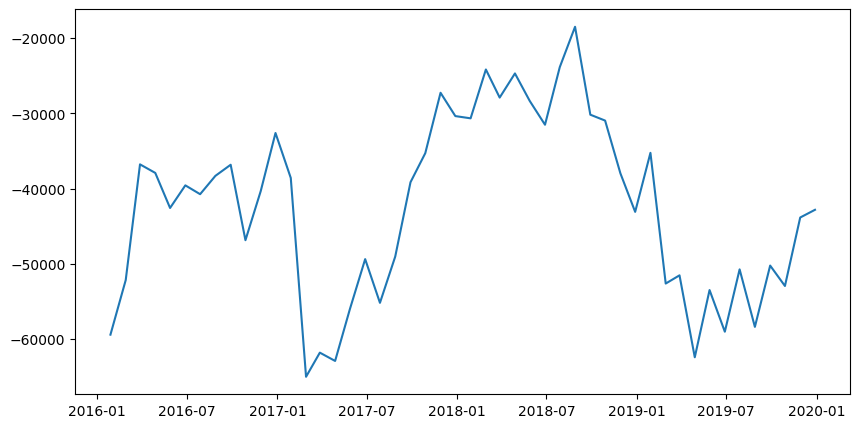

In [272]:
plt.figure(figsize=(10,5))
plt.plot(yellow['Seasonal Trips First Difference'])
plt.show()

In [273]:
from statsmodels.tsa.arima.model import ARIMA

In [286]:
len(yellow['trips_per_day'])
yellow.set_index('date',inplace=True)

In [287]:
# Para datos no estacionales
#Este código ajusta un modelo ARIMA (Autorregresión Integrada de Media Móvil) a la serie temporal, con orden de (1,1,1).
# En parámetro order debemos especificar p, d y q
model = ARIMA(yellow['trips_per_day'],order=(1,1,1)) # \Delta y_t = \psi_1y_{t-1} + \delta_1e_{t-1} + e_t
model_fit=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregres

In [288]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          trips_per_day   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -658.325
Date:                Sat, 08 Apr 2023   AIC                           1322.651
Time:                        18:37:37   BIC                           1328.883
Sample:                    01-01-2015   HQIC                          1325.084
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2442      0.971     -0.251      0.801      -2.148       1.659
ma.L1          0.3373      0.941      0.359      0.720      -1.507       2.181
sigma2      2.942e+08   1.26e-08   2.34e+16      0.000    2.94e+08    2.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.91   Prob(JB):                         0.79
Heteroskedasticity (H):               0.57   Skew:                            -0.06
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+32. Standard errors may be unstable.
"""

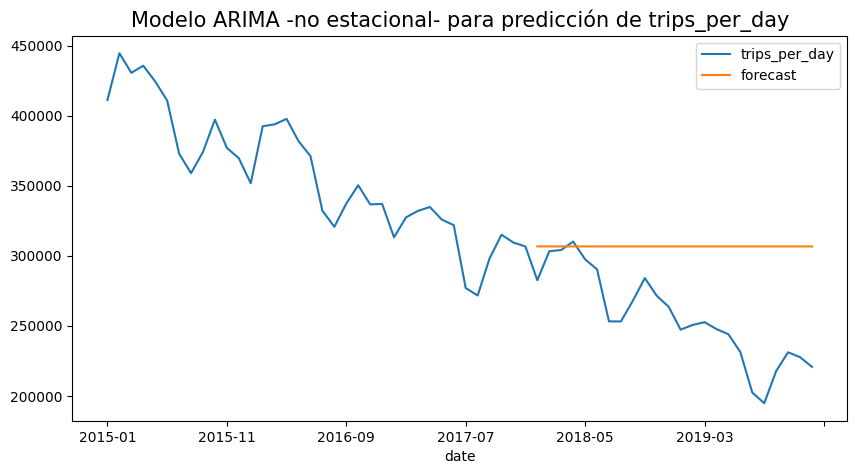

In [291]:
# El modelo ajustado se utiliza para hacer predicciones en el rango de índices de tiempo de 90 a 103 
# (que corresponden a los últimos 14 períodos de tiempo en la serie temporal), y los resultados se almacenan en la columna forecast del DataFrame df.
yellow['forecast']=model_fit.predict(start = 36, end = 60, dynamic = True)
yellow[['trips_per_day','forecast']].plot(figsize=(10,5))
# Se grafican tanto la serie temporal original de ventas como las predicciones generadas por el modelo ARIMA, utilizando el método plot() del DF. 
# El gráfico resultante tiene un tamaño de 15x8 y muestra la serie de ventas y las predicciones en función del tiempo. 
plt.title('Modelo ARIMA -no estacional- para predicción de trips_per_day', fontsize = 15)
plt.show()

No estamos obteniendo buenos resultados usando ARIMA porque nuestros datos tienen un comportamiento estacional, así que intentemos usar ARIMA estacional.

In [292]:
import statsmodels as sm

In [293]:
# Este código ajusta un modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) 
# El modelo SARIMAX tiene un orden de (1,1,1) para los términos ARIMA no estacionales y un orden estacional de (1,1,1,12), 
# lo que indica que se modela una estacionalidad de 12 meses.
# En el parámetro seasonal_orden debemos indicar = p estacional, d estacional, q estacional y periodicidad estacional
model=sm.tsa.statespace.sarimax.SARIMAX(yellow['trips_per_day'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59466D+01    |proj g|=  1.21889D+01

At iterate    5    f=  8.13701D+00    |proj g|=  2.00266D-01

At iterate   10    f=  8.13646D+00    |proj g|=  2.24601D-02

At iterate   15    f=  8.13447D+00    |proj g|=  8.60047D-01

At iterate   20    f=  8.11135D+00    |proj g|=  2.30098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   3.229D-03   8.110D+00
  F =   8.1104460533137726     

CONVERG

In [294]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      trips_per_day   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -486.627
Date:                            Sat, 08 Apr 2023   AIC                            983.254
Time:                                    18:41:50   BIC                            992.504
Sample:                                01-01-2015   HQIC                           986.735
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5289      0.629      0.841      0.400      -0.703       1.761
ma.L1         -0.5555      0.607     -0.915      0.360      -1.746       0.635
ar.S.L12      -0.2982      3.932     -0.076      0.940      -8.004       7.408
ma.S.L12       0.3037      3.906      0.078      0.938      -7.351       7.958
sigma2      5.713e+07   8.25e-07   6.93e+13      0.000    5.71e+07    5.71e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                11.62
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -1.00
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+29. Standard errors may be unstable.
"""

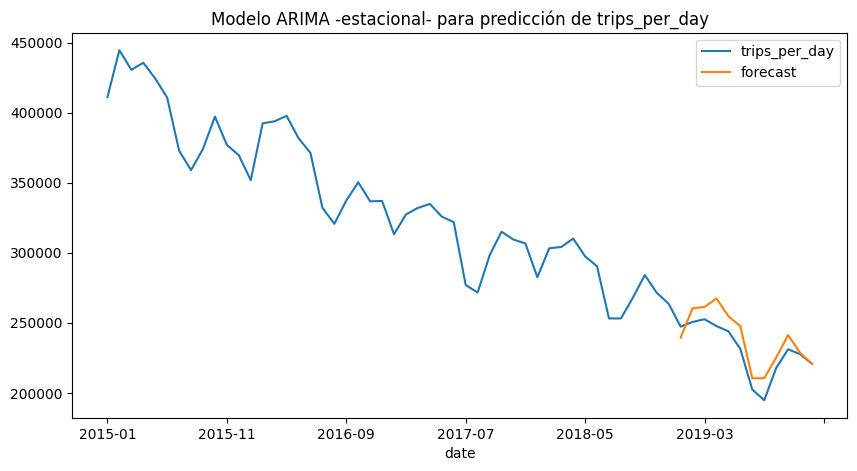

In [296]:
yellow['forecast']=results.predict(start=48,end=60,dynamic=True)
yellow[['trips_per_day','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de trips_per_day')
plt.show()

In [298]:
# Prediccion a 3 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(yellow.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(1, 37)]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 3 años = 36 meses

In [300]:
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=yellow.columns)

In [301]:
future_df = pd.concat([yellow,future_datest_df]) # Concatenamos los dos dataframes

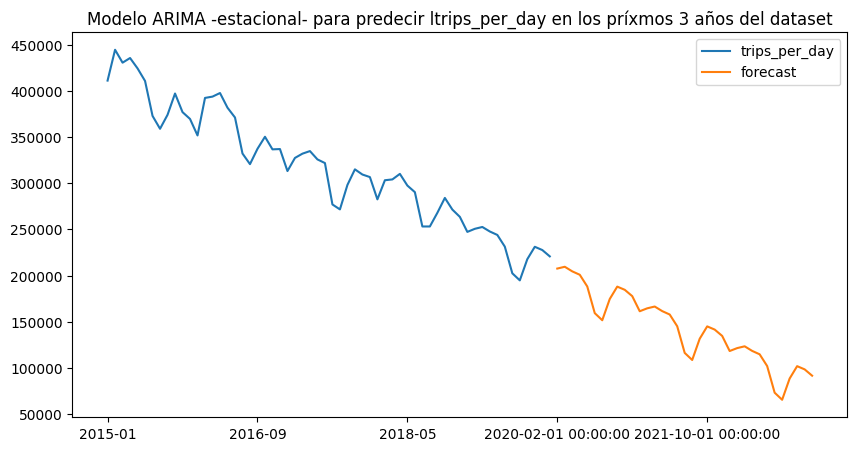

In [302]:
future_df['forecast'] = results.predict(start = 60, end = 96, dynamic= True)  
future_df[['trips_per_day', 'forecast']].plot(figsize=(10, 5)) 
plt.title('Modelo ARIMA -estacional- para predecir ltrips_per_day en los proximos 3 años del dataset')
plt.show()

In [303]:
future_df

,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,avg_hours_per_day_per_driver,...,week,trips_per_week,year,farebox_per_week,total_trips_per_day,shared_trips_per_day_percent,num_date,Trips First Difference,Seasonal Trips First Difference,forecast
2015-01,Yellow,411238,5442278,31236,13633,12721,28.9,13.4,21.5,7.9,...,4,2878666,2015,38095946,411238,0.0,735626,NaN,NaN,NaN
2015-02,Yellow,444633,6097785,30969,13617,12979,26.7,14.1,20.3,8.1,...,8,3112431,2015,42684495,444633,0.0,735657,33395.0,NaN,NaN
2015-03,Yellow,430669,6076181,31610,13584,13030,29.7,14.0,22.3,8.0,...,12,3014683,2015,42533267,430669,0.0,735685,-13964.0,NaN,NaN
2015-04,Yellow,435701,6226205,31574,13577,13098,28.9,14.2,21.9,8.1,...,17,3049907,2015,43583435,435701,0.0,735716,5032.0,NaN,NaN
2015-05,Yellow,424459,6239552,31442,13580,13006,29.7,14.1,22.4,8.1,...,21,2971213,2015,43676864,424459,0.0,735746,-11242.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65412.364182
2022-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88416.379110
2022-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101832.610232
2022-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98366.674555
